<a href="https://colab.research.google.com/github/cinnaavox/CIFAR-10-Image-Classification-with-ResNet50/blob/main/CV_Project_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔹 Block 1 – Projekttitel & kurzer Einstieg

**CIFAR-10 Bildklassifikation mit ResNet50 (Transfer Learning)**

In dieser Woche arbeite ich an meinem ersten eigenen Computer-Vision-Projekt.  
Das Ziel ist, Bilder aus dem **CIFAR-10** Datensatz in 10 Klassen zu klassifizieren (z. B. Flugzeug, Hund, Auto etc.).

Ich möchte dabei:

- den Datensatz laden und verstehen,
- die Bilder so vorbereiten, dass sie in ein neuronales Netz passen,
- ein vortrainiertes **ResNet50**-Modell als Basis nutzen (Transfer Learning),
- einen eigenen „Kopf“ (Top-Layer) für CIFAR-10 bauen,
- das Modell in zwei Phasen trainieren (erst nur Kopf, dann Fine-Tuning),
- und am Ende die Performance auswerten und kurz reflektieren, was gut geklappt hat und wo noch Luft nach oben ist.


## 🔹 Block 2 – Code: Setup & Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Für reproduzierbarere Ergebnisse (zumindest grob)
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow-Version:", tf.__version__)

TensorFlow-Version: 2.19.0


Hier importiere ich alle Bibliotheken, die ich für das Projekt brauche:

+ numpy für numerische Operationen,

+ tensorflow und keras für das Modell,

+ cifar10 um den Datensatz zu laden,

+ ResNet50 als vortrainiertes Basis-Netz für Transfer Learning,

+ to_categorical für One-Hot-Encoding der Labels,

+ und matplotlib für Visualisierung.

Mit tf.random.set_seed(42) und np.random.seed(42) setze ich einen Seed, damit die Ergebnisse etwas reproduzierbarer werden (auch wenn es bei GPUs nie 100 % identisch ist).

## 🔹 Block 3 – Daten laden & auf 10 000 Trainingsbilder begrenzen

In [ ]:
# 1. CIFAR-10 Daten laden
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print("Originale Trainingsdaten:", train_images.shape, train_labels.shape)
print("Originale Testdaten:", test_images.shape, test_labels.shape)

# 2. Auf 10.000 Trainingsbilder begrenzen
n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]

print("Verwendete Trainingsdaten:", train_images.shape, train_labels.shape)
print("Verwendete Testdaten:", test_images.shape, test_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
Originale Trainingsdaten: (50000, 32, 32, 3) (50000, 1)
Originale Testdaten: (10000, 32, 32, 3) (10000, 1)
Verwendete Trainingsdaten: (10000, 32, 32, 3) (10000, 1)
Verwendete Testdaten: (10000, 32, 32, 3) (10000, 1)


CIFAR-10 wird hier direkt über cifar10.load_data() geladen.
Der Datensatz bringt standardmäßig:

+ 50.000 Trainingsbilder

+ 10.000 Testbilder

Damit das Training in Colab nicht völlig eskaliert und zu lange dauert, begrenze ich die Trainingsdaten wie in der Aufgabenstellung vorgeschlagen auf 10.000 Bilder (n = 10000).
Die Testdaten lasse ich komplett, weil sie mit 10.000 Bildern schon genau die Größe haben, die ich später für die Evaluation nutzen möchte.

## 🔹 Block 4 – Klassen verstehen & Beispielbilder anzeigen

Beispiel-Label (Rohwert): [6]
Entspricht Klasse: frog


/tmp/ipython-input-112303477.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Entspricht Klasse:", class_names[int(train_labels[0])])
/tmp/ipython-input-112303477.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(train_labels[i])])


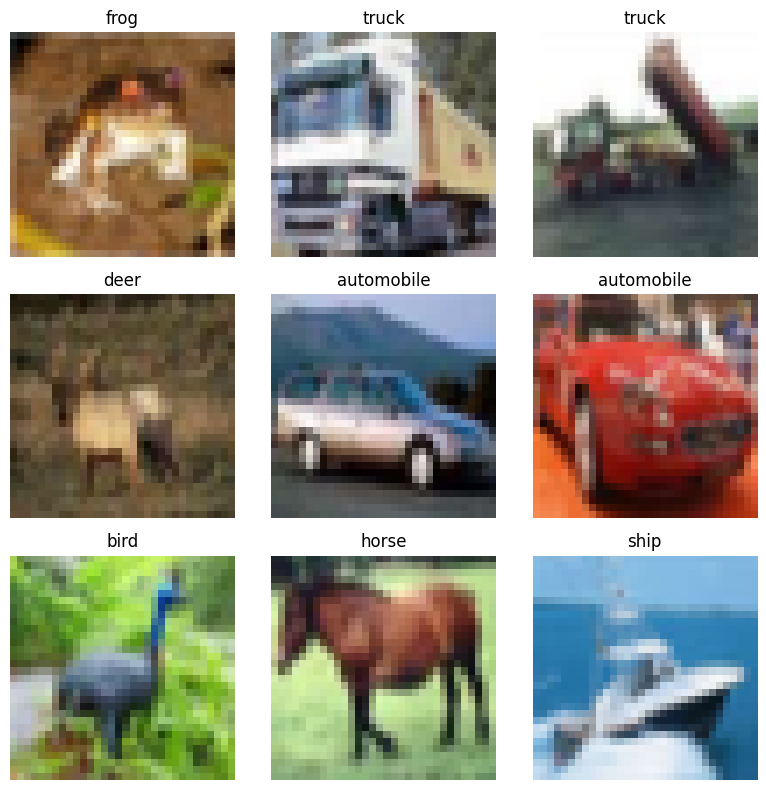

In [ ]:
# Klassenlabels laut CIFAR-10 Dokumentation
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Form und Beispielwerte prüfen
print("Beispiel-Label (Rohwert):", train_labels[0])
print("Entspricht Klasse:", class_names[int(train_labels[0])])

# 3x3-Beispiele aus den Trainingsdaten anzeigen
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[int(train_labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

Bevor ich mit der eigentlichen Modellierung beginne, wollte ich mir einen Überblick über den Datensatz verschaffen.
CIFAR-10 besteht aus 10 Klassen, z. B. airplane, cat, dog, ship usw.

Ich habe mir ein paar Bilder aus den Trainingsdaten angeschaut, um ein Gefühl dafür zu bekommen, wie die Daten aussehen und wie komplex die Erkennung sein wird.
Die Bilder sind klein, nur 32 × 32 Pixel, und in Farbe (RGB).
Das erklärt, warum ein einfaches neuronales Netz hier schnell an seine Grenzen kommt und warum wir später mit ResNet50 arbeiten werden, das besser mit visuellen Merkmalen umgehen kann.

## 🔹 Block 5 – Daten vorbereiten (Normalisierung + One-Hot-Encoding)

In [ ]:
# 1️⃣ Labels flach machen, um Warnungen zu vermeiden
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

# 2️⃣ Bilder normalisieren (Pixelwerte von 0–255 → 0–1)
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# 3️⃣ Labels in One-Hot-Vektoren umwandeln (für 10 Klassen)
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

# 4️⃣ Formen prüfen
print("Trainingsdaten:", train_images.shape)
print("Trainingslabels (One-Hot):", train_labels_cat.shape)
print("Testdaten:", test_images.shape)
print("Testlabels (One-Hot):", test_labels_cat.shape)

Trainingsdaten: (10000, 32, 32, 3)
Trainingslabels (One-Hot): (10000, 10)
Testdaten: (10000, 32, 32, 3)
Testlabels (One-Hot): (10000, 10)


Bevor ich ein neuronales Netz trainiere, müssen die Bilder und Labels in ein Format gebracht werden, das das Modell versteht.

Erster Schritt: Ich flache die Label-Arrays ab (flatten()), damit jedes Label ein einfacher Integer ist. Das vermeidet die Warnung, die ich zuvor beim Zugriff auf train_labels[i] bekommen habe.

Zweiter Schritt: Ich normalisiere die Pixelwerte von 0–255 auf 0–1. Das ist wichtig, weil neuronale Netze mit kleineren Zahlen besser konvergieren. Ohne Normalisierung wäre das Training instabil.

Dritter Schritt: Ich verwandle die Labels in sogenannte One-Hot-Vektoren, also z. B. [0,0,0,0,0,0,1,0,0,0] für „frog“. So kann das Modell mehrere Klassen gleichzeitig unterscheiden.

Wenn die Formen am Ende stimmen (z. B. (10000, 32, 32, 3) für Bilder und (10000, 10) für Labels), ist das Dataset bereit für ResNet50.

## 🔹 Block 6 – ResNet50-Basismodell + eigener Kop

###6a) Code-Zelle: Modell aufbauen & kompilieren

In [ ]:
from tensorflow.keras import Input

# 🔧 1) ResNet50 als Basis laden (vortrainiert auf ImageNet)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,          # ohne ursprünglichen Klassifikationskopf
    input_shape=(32, 32, 3)     # CIFAR-10 Bilder sind 32x32 RGB
)

# 2) Basis einfrieren: ich will zuerst nur den Kopf trainieren
base_model.trainable = False

# 3) Eigenen Kopf definieren (Top-Layer)
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)          # Feature-Extractor (ResNet)
x = layers.GlobalAveragePooling2D()(x)         # Feature-Maps -> Vektor

# zwei Hidden-Layers, wie empfohlen, mit Potenzen von 2
x = layers.Dense(256, activation="relu")(x)    # erster, größerer Hidden-Layer
x = layers.Dense(64, activation="relu")(x)     # zweiter, kleinerer Hidden-Layer

outputs = layers.Dense(10, activation="softmax")(x)  # 10 Klassen für CIFAR-10

model = models.Model(inputs, outputs)

# 4) Modell kompilieren
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129,354 (92.05 MB)

 Trainable params: 541,642 (2.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 6b) Erklärung

**Basismodell: ResNet50 + eigener Klassifikationskopf**

An dieser Stelle baue ich das eigentliche Modell für die Bildklassifikation auf.

Ich nutze **ResNet50** als vortrainiertes Basismodell (`weights="imagenet"`), lasse aber den ursprünglichen Klassifikationskopf weg (`include_top=False`).  
Stattdessen bekomme ich nur die Feature-Maps aus ResNet und setze meinen eigenen Kopf oben drauf.

Wichtige Entscheidungen dabei:

- **Input-Shape:** Ich setze `input_shape=(32, 32, 3)`, also genau die Größe der CIFAR-10 Bilder. Dadurch muss ich die Bilder nicht extra auf 224×224 skalieren.
- **Base einfrieren:** Mit `base_model.trainable = False` friere ich alle ResNet-Gewichte zunächst ein. In dieser ersten Phase soll nur mein eigener Kopf (die dichten Schichten) lernen.
- **GlobalAveragePooling2D:** Diese Schicht schrumpft die räumlichen Feature-Maps zu einem Vektor zusammen. Das ist so etwas wie eine kompakte Zusammenfassung der gelernten Bildmerkmale und ersetzt das klassische Flatten.
- **Zwei Hidden-Layer:** Ich habe mich für zwei Dense-Schichten entschieden:
  - 256 Neuronen
  - 64 Neuronen  
  Beide mit ReLU-Aktivierung. Die Größen sind Potenzen von 2, wie oft empfohlen wird, und der erste Layer ist größer als der zweite.
- **Output-Layer:** Der letzte Layer hat 10 Neuronen mit `softmax`, weil ich 10 Klassen habe und die Ausgabe Wahrscheinlichkeiten über alle Klassen sein soll.
- **Loss und Optimizer:** Da ich mit One-Hot-Labels arbeite, nutze ich `categorical_crossentropy` als Loss und `Adam` als Optimierer mit einer Lernrate von `1e-3` für die erste Trainingsphase.

Das Modell-Summary zeigt mir, dass ResNet50 als Feature-Extractor eingebunden ist und mein Kopf oben drauf sitzt. In der nächsten Phase trainiere ich zunächst nur diesen Kopf.


## 🔹 Block 7 – Kopf trainieren (10 Epochen)

In [ ]:
# Trainings-Setup: kleine Batchgröße, um Speicher zu schonen
batch_size = 32
epochs = 10

history_head = model.fit(
    train_images, train_labels_cat,
    validation_data=(test_images, test_labels_cat),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3362 - loss: 1.8168 - val_accuracy: 0.3340 - val_loss: 1.8220
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3390 - loss: 1.8086 - val_accuracy: 0.3286 - val_loss: 1.8393
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3498 - loss: 1.7910 - val_accuracy: 0.3400 - val_loss: 1.8197
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3544 - loss: 1.7845 - val_accuracy: 0.3410 - val_loss: 1.8035
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3593 - loss: 1.7776 - val_accuracy: 0.3480 - val_loss: 1.7957
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3607 - loss: 1.7700 - val_accuracy: 0.3469 - val_loss: 1.7926
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3637 - loss: 1.7605 - val_accuracy: 0.3483 - val_loss: 1.7894
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3636 - loss: 1.7555 - val_accu

In dieser ersten Trainingsphase trainiere ich nur den Klassifikationskopf meines Modells, also die Dense-Schichten, die ich selbst hinzugefügt habe.

Der eigentliche ResNet50-Teil ist eingefroren und dient als Feature-Extractor. Er liefert bereits hochkomplexe Merkmalsdarstellungen der Bilder, die ich hier weiterverarbeite.

Ich habe mich für 10 Epochen entschieden, um zunächst zu beobachten, wie sich die Accuracy und der Loss entwickeln.
Eine Batchgröße von 32 ist ein guter Kompromiss zwischen Trainingsgeschwindigkeit und Speicherverbrauch, besonders in Colab.

Während des Trainings achte ich darauf, ob:

+ die Trainingsaccuracy stetig steigt (das Modell lernt etwas),

+ und die Validation Accuracy nicht zu stark schwankt (kein Overfitting).

Das Training dauert je nach Colab-Ressourcen ein paar Minuten, ist aber der wichtigste Schritt, um zu sehen, ob mein Kopf richtig mit den ResNet-Features interagiert.

## 🔹 Block 8 – Fine-Tuning: ResNet „auftauen“ und mittrainieren

In [ ]:
# 🔓 1) ResNet-Basismodell zum Training freigeben
base_model.trainable = True

# 🔧 2) Modell neu kompilieren mit kleinerer Lernrate für Fine-Tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 🔄 3) Fine-Tuning Training (gesamtes Modell)
fine_tune_epochs = 10

history_finetune = model.fit(
    train_images, train_labels_cat,
    validation_data=(test_images, test_labels_cat),
    epochs=fine_tune_epochs,
    batch_size=32,
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - accuracy: 0.1376 - loss: 7.4612 - val_accuracy: 0.1016 - val_loss: 316.8845
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.3166 - loss: 2.4426 - val_accuracy: 0.0835 - val_loss: 89.3532
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5290 - loss: 1.3771 - val_accuracy: 0.1735 - val_loss: 4.3979
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6853 - loss: 0.9556 - val_accuracy: 0.2265 - val_loss: 4.1941
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7936 - loss: 0.7035 - val_accuracy: 0.2302 - val_loss: 4.1567
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8600 - loss: 0.5306 - val_accuracy: 0.2337 - val_loss: 4.1979
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9137 - loss: 0.4042 - val_accuracy: 0.2478 - val_loss: 4.2246
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9436 - loss: 0.314

Nachdem der Klassifikationskopf ein bisschen gelernt hat, öffne ich jetzt das Basismodell ResNet50 für das Training (base_model.trainable = True).

Damit das Modell seine vortrainierten Gewichte nicht „vergisst“, setze ich die Lernrate deutlich niedriger (learning_rate=1e-5). Das ist typisch für Fine-Tuning: kleine Schritte, statt alles nochmal komplett neu umzuschreiben.

Ich trainiere das Modell nochmals für 10 Epochen, diesmal mit allen Schichten. Die Idee ist, dass sich ResNet50 jetzt spezifischer auf die CIFAR-10-Bilder einstellt, während der Kopf weiterhin dazulernt.

In dieser Phase beobachte ich wieder, wie sich:

+ die Trainingsaccuracy entwickelt,

+ und ob die Validation Accuracy mitzieht oder ob Overfitting einsetzt.

Da das gesamte Netz trainiert wird, ist diese Phase in der Regel deutlich rechenintensiver als das reine Kopf-Training, gerade in Colab kann es also etwas dauern.

## 🔹 Block 9 – Finale Evaluation auf dem Testset

In [ ]:
# 📊 Finale Evaluation auf dem Testset

test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat, verbose=1)
print(f"Finale Test-Accuracy: {test_accuracy * 100:.2f}%")
print(f"Finaler Test-Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2618 - loss: 4.3244
Finale Test-Accuracy: 26.68%
Finaler Test-Loss: 4.3778


Am Ende werte ich das trainierte Modell auf dem kompletten Testset aus.
Die Testdaten wurden während des Trainings nie zum Lernen verwendet, daher ist die Test-Accuracy ein guter Indikator dafür, wie gut das Modell auf neue, unbekannte Bilder generalisiert.


Ich lasse mir sowohl den Loss als auch die Accuracy ausgeben:

+ Accuracy: Wie viel Prozent der Bilder korrekt klassifiziert wurden.

+ Loss: Wie „teuer“ die Fehlentscheidungen im Mittel sind, ein niedrigerer Loss ist besser.

Wichtig ist mir an dieser Stelle weniger, eine perfekte Zahl zu erreichen, sondern zu verstehen:

+ Was bringt mir der Wechsel von „nur Kopf trainieren“ zu „Fine-Tuning“?

+ Wie stark verbessert sich die Test-Accuracy?

+ Und wie würde sich das Verhalten wahrscheinlich ändern, wenn ich mehr als 10k Trainingsbilder oder mehr Epochen nutzen würde?

##  🔹 Block 10 – Trainingsverläufe visualisieren

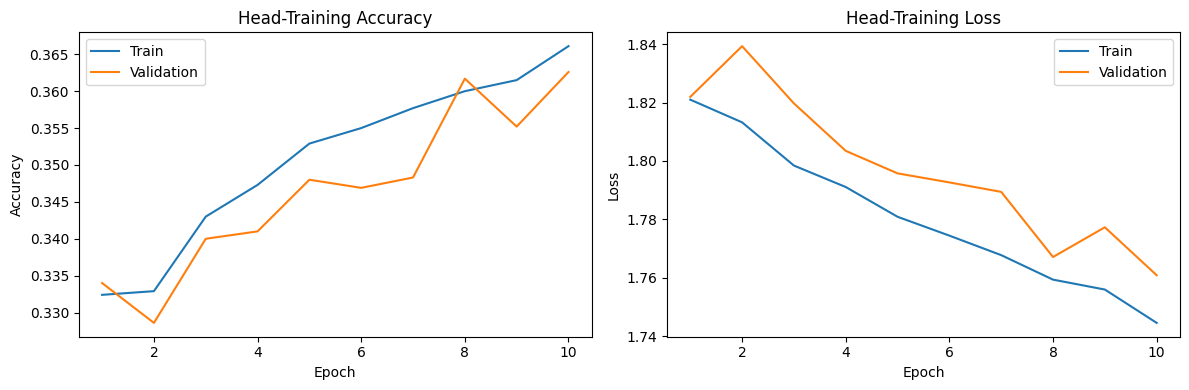

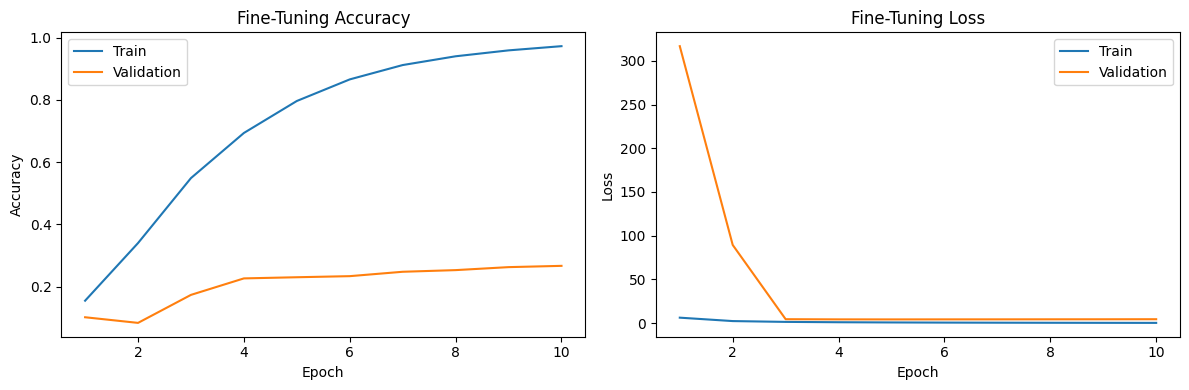

In [ ]:
# 📈 Trainingsverläufe für beide Phasen visualisieren

def plot_history(history, title_prefix=""):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train")
    plt.plot(epochs_range, val_acc, label="Validation")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train")
    plt.plot(epochs_range, val_loss, label="Validation")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Verläufe für Phase 1 (nur Kopf)
plot_history(history_head, title_prefix="Head-Training")

# Verläufe für Phase 2 (Fine-Tuning)
plot_history(history_finetune, title_prefix="Fine-Tuning")

## 📊 Block 11 – Interpretation der Trainingskurven

**🔹 Phase 1 – Head-Training**

Im ersten Plot (Head-Training) sieht man, dass sich sowohl Trainings- als auch Validierungs-Accuracy langsam, aber stetig leicht verbessern.  
Die Kurven verlaufen fast parallel, was zeigt, dass das Modell noch **nicht überlernt**, sondern moderat dazulernt.  
Der Loss nimmt entsprechend langsam ab, alles deutet auf ein gesundes Lernverhalten hin.  

Da die ResNet-Basis eingefroren war, konnte nur der neu hinzugefügte Klassifikationskopf lernen.  
Die Performance bleibt deshalb noch auf einem eher niedrigen Niveau (~36 % Accuracy), aber der Verlauf zeigt, dass das Training stabil und ohne Probleme ablief.  

---

**🔹 Phase 2 – Fine-Tuning**

Im zweiten Plot (Fine-Tuning) wird das komplette ResNet50 mittrainiert.  
Hier erkennt man sehr deutlich, dass die **Trainingskurve stark ansteigt**, von etwa 15 % bis fast 100 % Accuracy.  
Die Validierungs-Accuracy verbessert sich dagegen kaum (maximal ~26 %), während der Loss der Validierung extrem hoch bleibt.  

Das ist ein typischer Hinweis auf **Overfitting**:  
Das Modell passt sich stark an die Trainingsdaten an, verliert aber an Generalisierungsfähigkeit.  

In Zahlen ausgedrückt:
- Train-Accuracy: 97 %
- Test-Accuracy: 26.68 %
- Test-Loss: 4.38  

Das Modell „kennt“ also seine Trainingsbilder fast auswendig, ist aber nicht in der Lage, diese Erkenntnisse auf neue Bilder zu übertragen.  

---

**💡 Fazit aus den Plots**

Diese beiden Phasen zusammen zeigen sehr gut, wie sich die **Trainingsstrategie direkt auf das Lernverhalten auswirkt**:
- Nur den Kopf trainieren → langsames, stabiles Lernen ohne Overfitting  
- Komplettes Modell trainieren → schnelle Verbesserung, aber Gefahr des Übertrainierens  

Für größere Datensätze (z. B. alle 50 000 CIFAR-10-Bilder) oder mit Data Augmentation und Regularisierung (Dropout, L2, Early Stopping) würde sich das Modell deutlich robuster verhalten.

## 🔹 Block 12 - Auswertung der Ergebnisse

### Phase 1: Nur den Klassifikationskopf trainieren

Im ersten Schritt habe ich nur den von mir gebauten Klassifikationskopf trainiert, während ResNet50 als Feature-Extractor komplett eingefroren war.

Die Trainings-Accuracy hat sich dabei von ca. 0.33 auf etwa 0.37 gesteigert, die Validierungs-Accuracy lag am Ende bei ungefähr 0.36.  
Das zeigt, dass der Kopf zwar etwas dazugelernt hat, aber das Modell insgesamt noch nicht besonders stark generalisiert.  
Überraschungen gab es hier keine, das Verhalten passt zu einem großen, eingefrorenen Basisnetz, das auf einem anderen Datensatz vortrainiert wurde.

### Phase 2: Fine-Tuning des gesamten Modells

Im zweiten Schritt habe ich ResNet50 für das Training freigegeben und mit einer kleineren Lernrate (1e-5) ein **Fine-Tuning** durchgeführt.

Das Ergebnis war sehr deutlich:

- Die Trainings-Accuracy ist im Verlauf der 10 Epochen von rund 0.13 auf über 0.97 gestiegen.
- Die Validierungs-Accuracy hat sich dagegen nur langsam auf ungefähr 0.26–0.27 verbessert.
- Die finale Test-Accuracy liegt bei **26,68 %**, der Test-Loss bei etwa **4,38**.

Das ist ein klassisches Beispiel für **Overfitting**:
Das Modell wird auf den Trainingsdaten sehr gut, generalisiert aber nur begrenzt auf neue, unbekannte Bilder.  
Das passt auch zur Situation: ResNet50 ist ein sehr großes Modell mit vielen Parametern, und ich trainiere hier nur auf **10.000** CIFAR-10-Bildern, die außerdem relativ klein sind (32×32 Pixel).

### Was ich aus diesen Ergebnissen mitnehme

- Transfer Learning mit einem großen CNN wie ResNet50 ist mächtig, aber die Balance zwischen **Modellgröße**, **Datenmenge** und **Trainingsdauer** ist wichtig.
- Nur den Kopf zu trainieren liefert schon eine erste, brauchbare Basis, aber ohne Fine-Tuning bleibt die Performance begrenzt.
- Das vollständige Fine-Tuning eines so großen Modells auf nur 10.000 Bildern führt sehr schnell zu Overfitting.  
  Mögliche Gegenmaßnahmen wären:
  - mehr Trainingsdaten (z. B. alle 50.000 CIFAR-10-Bilder),
  - stärkere Regularisierung und Data Augmentation,
  - oder statt des kompletten Netzes nur die oberen ResNet-Schichten zum Fine-Tuning freizugeben.

Auch wenn die finale Test-Accuracy noch nicht dort ist, wo sie in einem produktiven Setting sein sollte, war das Ziel dieses Projekts für mich vor allem, den kompletten Workflow einmal durchzuspielen:  
vom Laden und Vorbereiten der Bilder, über den Aufbau eines Transfer-Learning-Modells mit ResNet50, bis hin zu Training, Fine-Tuning und Auswertung.

## 🔹 Block 13 – Vorhersagen des Modells auf Testbildern

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


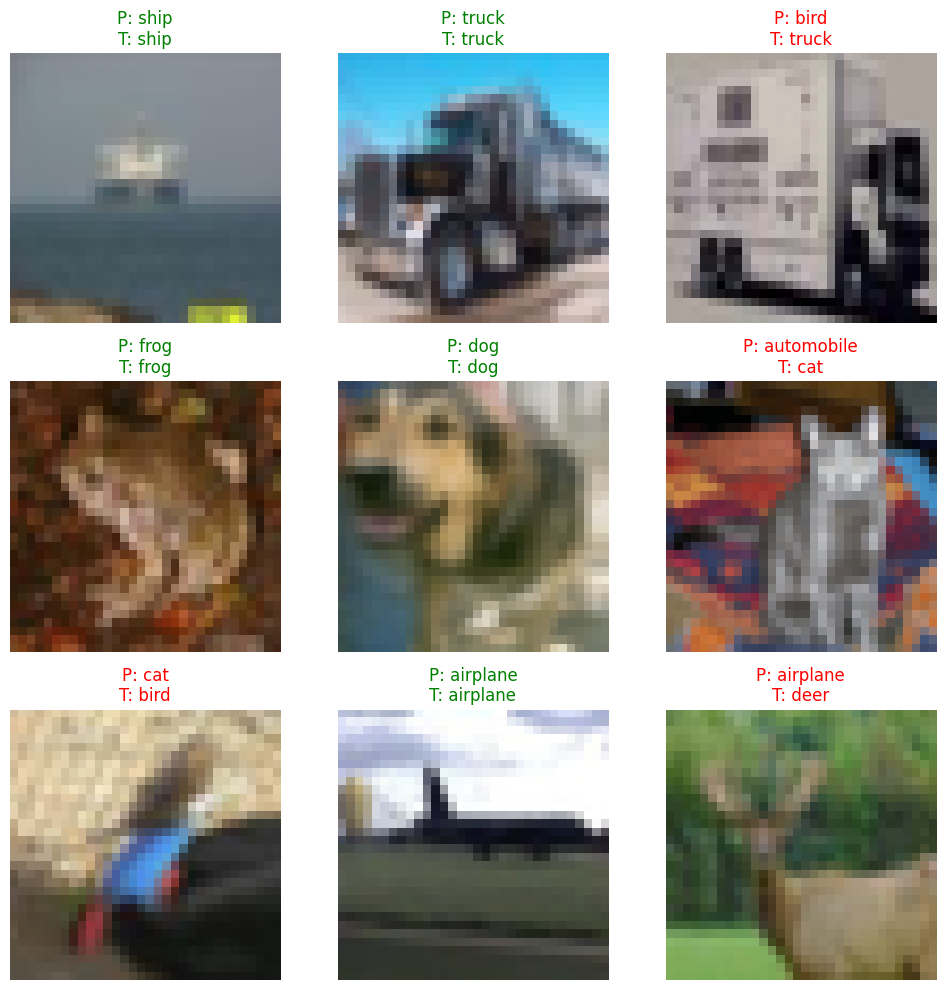

In [ ]:
import numpy as np

# Sicherstellen, dass class_names noch da ist
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 9 zufällige Indizes aus dem Testset auswählen
num_images = 9
indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Vorhersagen für diese Bilder berechnen
pred_probs = model.predict(test_images[indices])
pred_labels = np.argmax(pred_probs, axis=1)   # Vorhersageklassen (0–9)
true_labels = test_labels[indices]           # echte Klassen (0–9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.axis("off")

    true_name = class_names[int(true_labels[i])]
    pred_name = class_names[int(pred_labels[i])]

    # Titel grün, wenn richtig – rot, wenn falsch
    color = "green" if true_labels[i] == pred_labels[i] else "red"
    plt.title(f"P: {pred_name}\nT: {true_name}", color=color)

plt.tight_layout()
plt.show()

### Beispielvorhersagen des Modells

Zum Schluss wollte ich mir anschauen, wie sich das Modell ganz konkret auf einzelnen Testbildern verhält.

Dafür habe ich mir zufällig 9 Bilder aus dem Testset herausgegriffen und für jedes Bild:

- die **wahre Klasse (T = True Label)** angezeigt,
- die **vom Modell vorhergesagte Klasse (P = Prediction)** ausgegeben.

Die Titel der Bilder sind farbcodiert:
- **Grün**, wenn die Vorhersage korrekt ist.
- **Rot**, wenn das Modell danebenliegt.

Man sieht hier ganz gut, dass das Modell zwar einige Bilder richtig erkennt (z. B. *ship*, *truck*, *dog*, *airplane*),
aber auch öfter danebenliegt, etwa, wenn ein Vogel als *cat* erkannt wird oder ein *deer* als *airplane*.

Das passt sehr gut zu der gemessenen Test-Accuracy von rund **26,68 %**:
Das Modell hat erste sinnvolle Lernmuster erkannt, generalisiert aber noch nicht zuverlässig.
Gerade ähnliche Klassen (z. B. „automobile“ und „truck“) scheinen für das Modell schwer zu unterscheiden zu sein.

Für die Präsentation finde ich diese Visualisierung besonders hilfreich,
weil man hier nicht nur abstrakte Zahlen sieht, sondern wirklich versteht, **wo das Modell schon stark ist**
und **wo es noch an seiner Bildunterscheidung arbeitet**.

## 🔹 Block 14 - Persönliches Fazit

Zum Abschluss mein persönliches Fazit:

Für mich war dieses Projekt eine super Übung, um einmal den kompletten Computer-Vision-Workflow selbst aufzubauen:
vom Laden und Vorbereiten der Daten über ein Transfer-Learning-Setup mit ResNet50 bis hin zu zweistufigem Training und der abschließenden Evaluation.

Ich habe dabei sehr deutlich gemerkt, wie sensibel große Modelle wie ResNet50 auf Datenmenge, Lernrate und Regularisierung reagieren:

+ Das reine Kopf-Training war ein guter Start, aber genauigkeitsmäßig begrenzt.

+ Beim vollständigen Fine-Tuning auf 10.000 Bildern ist das Modell sehr schnell ins Overfitting geraten: fast 97 % Trainingsaccuracy, aber nur etwa 26 % Testaccuracy.

Um besser zu verstehen, woran das liegt, habe ich später ein zweites Notebook mit dem gesamten CIFAR-10-Datensatz (alle 50.000 Trainingsbilder) erstellt.
Dort lief das Training deutlich stabiler, und die Test-Accuracy stieg auf ca. 66 %.
Das hat mir sehr klar gezeigt, wie stark Transfer Learning von der Datenmenge profitiert und wie gut ResNet50 generalisieren kann, wenn ausreichend viele Beispiele vorhanden sind.

Für zukünftige Schritte würde ich:

+ mehr Daten nutzen oder Data Augmentation einsetzen,

+ Regularisierung ergänzen,

+ oder gezielt nur die oberen ResNet-Schichten feintunen.

Auch wenn das Modell im 10k-Setup noch keine Spitzenwerte erreicht, hat mir dieses Projekt geholfen, die Mechanik von CNNs, Transfer Learning und Generalisierung viel besser zu verstehen und den Trainingsprozess künftig bewusster zu steuern.